# Drug Discovery

This is a demo to explore potential drugs on [A single-cell atlas of the peripheral immune response in patients with severe COVID-19 data](https://www.nature.com/articles/s41591-020-0944-y) based on BRICK.

## Load packages and data

In [46]:
import BRICK
import scanpy as sc

url = "neo4j://10.224.28.66:7687"
auth = ("neo4j", "bmVvNGpwYXNzd29yZA==")  

BRICK.config(url=url, auth=auth)

In [2]:
adata = sc.read('../Virus_Pertubation/Original_Data/Single_cell_atlas_of_peripheral_immune_response_to_SARS_CoV_2_infection.h5ad')
adata

AnnData object with n_obs × n_vars = 44721 × 26361
    obs: 'Admission', 'ClusterID', 'DPS', 'DTF', 'Donor_full', 'HLA1', 'IFN1', 'Sex', 'Status', 'Ventilated', 'cell_type_coarse', 'cell_type_fine', 'nCount_RNA', 'nCount_SCT', 'nFeature_RNA', 'nFeature_SCT', 'percent_mt', 'percent_rpl', 'percent_rps', 'percent_rrna', 'seurat_clusters', 'singler'
    var: 'Selected', 'sct_detection_rate', 'sct_gmean', 'sct_residual_mean', 'sct_residual_variance', 'sct_variable', 'sct_variance'
    uns: 'assay', 'authors', 'disease', 'organism', 'preprint', 'short_name', 'tissue'
    obsm: 'X_pca', 'X_umap'
    varm: 'pca_feature_loadings'
    layers: 'matrix', 'norm_data', 'scale_data'

/home/share/huadjyin/home/s_caolei2/.conda/envs/openhgnn/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/share/huadjyin/home/s_caolei2/.conda/envs/openhgnn/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


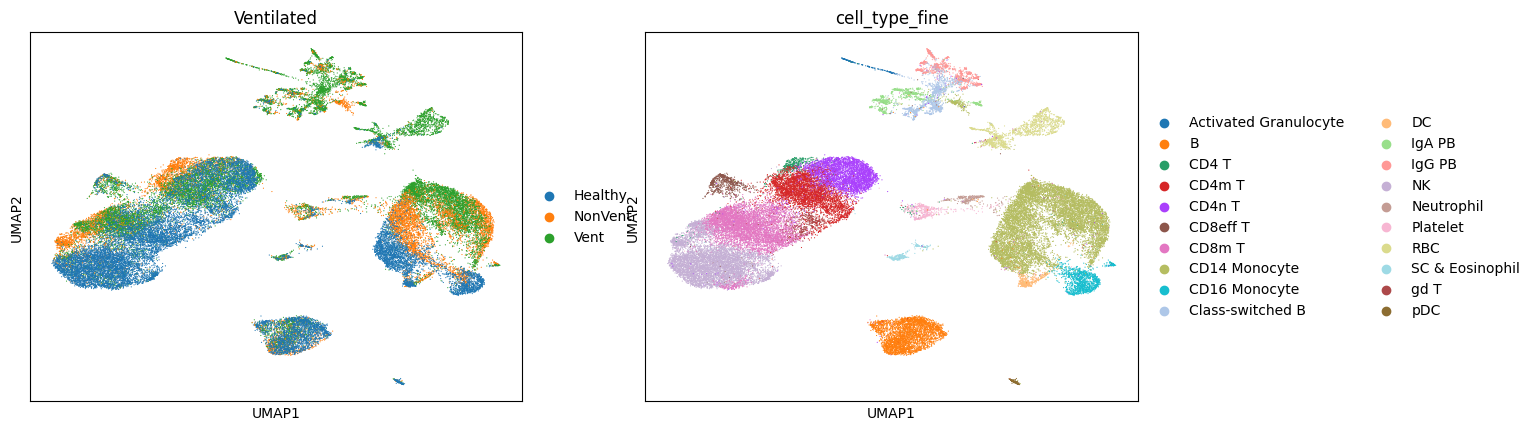

In [3]:
sc.pl.umap(adata, color = ['Ventilated', 'cell_type_fine'])

## Differential Expression Gene analysis

Here we take **CD14 monocyte** as example and calculate diffferential expression gene both on celltype and cell state. With top DEG number as 100, the final Geneset is composed of 100 DEG for CD14 monocyte as well as for Healthy, NonVert and Vent in CD14 monocyte respectively.

In [ ]:
select_celltype = 'Neutrophil'
N_top_genes = 100

geneset = set()

# 100 DEG from CD14 monocyte
sc.tl.rank_genes_groups(adata, 'cell_type_fine')
BRICK.pp.rank_genes_groups2df(adata)
for x in list(adata.uns['rank_genes_groups_df'][select_celltype]['names'])[:N_top_genes]:
    geneset.add(x)

# 100 DEG from different cell state of monocyte
adata_sub = adata[adata.obs['cell_type_fine'] == select_celltype].copy()
sc.tl.rank_genes_groups(adata_sub, 'Ventilated')
BRICK.pp.rank_genes_groups2df(adata_sub)
for cell_state in adata_sub.uns['rank_genes_groups_df'].values():
    for x in list(cell_state['names'])[:N_top_genes]:
        geneset.add(x)

print(len(geneset))

## Query Knowledge Graph

this might some time because gene might related to many entities.

In [ ]:
df = BRICK.qr.query_neighbor(geneset, source_entity_type='Gene',
                             target_entity_type=['Disease','Phenotype',
                                                 'Process','Cell_Component','Pathway', 'Function',
                                                 'Tissue','Cell',
                                                 'Chemical','Stage'], return_type='triplet')

## Filter target entity 
by pvalue with cut-off as 0.01

In [ ]:
df_count = BRICK.rk.enrich(df)
df_count_filtered = df_count.loc[df_count['pvalue'] < 0.01]

In [47]:
# abort
import pickle

select_celltype = 'Neutrophil'
with open(f'df_count_{select_celltype}.pickle', 'rb') as f:
    df_count = pickle.load(f)

df_count_filtered = df_count.loc[df_count['pvalue'] < 0.01]
df_count_filtered.head()

,path.0.name,path.2.id,path.2.name,path.2.type,path.2.match_count,path.2.background_count,pvalue
25,"[ISG15, CD36, CD163, KLF4, CD83, SOCS3, MBD2, ...",CHEBI:4806,(-)-epigallocatechin 3-gallate,Chemical,50,1788,0.002535
79,"[MBD2, SELL, NR4A2, IRF1, MAPK14]",CHEBI:35628,(6-methoxy-2-naphthyl)acetic acid,Chemical,5,55,0.003955
87,"[H6PD, CD36, PPIG, SAT1, THBS1, SOD2, NCF1, PT...",CHEBI:58968,(E)-4-hydroxynon-2-enal,Chemical,31,914,0.000986
94,"[JUND, JUNB, JUN, FOSB, FOS]",CHEBI:28985,"(R)-1,2-epoxypropane",Chemical,5,13,0.000011
137,"[KLF4, PTEN, JUND, JUNB, JUN, FOSB, FOS, CDKN1A]",CHEBI:34019,(S)-ATPA,Chemical,8,82,0.000189


## Construct Graph 
Construct Graph with adata and queried df from Knowledge Graph

In [48]:
# abort
adata_sub = sc.read(f'./{select_celltype}.h5ad')
geneset = set(adata_sub.uns['query_gene_set'])

In [49]:
nxg = BRICK.pp.combine_graph(adata_sub[:, list(geneset)], df_count_filtered)

print(len(nxg.nodes))

2990


In [59]:
model = BRICK.emb.GRACE_model(nxg, device='cuda:1')

(T):   0%|          | 0/1000 [00:00<?, ?it/s]/home/share/huadjyin/home/s_caolei2/.conda/envs/openhgnn/lib/python3.8/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)
(T): 100%|██████████| 1000/1000 [00:14<00:00, 67.31it/s, loss=6.08]


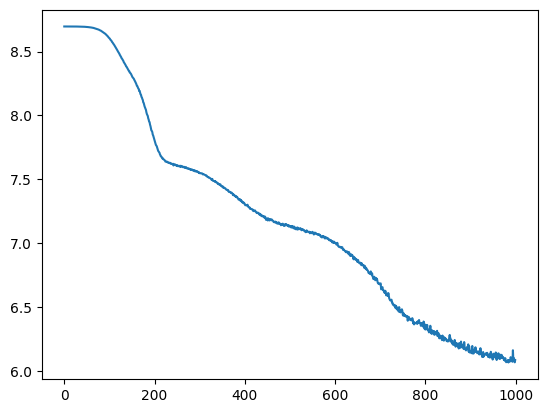

In [60]:
model.fit(epoches=1000)
model.plot_loss()

In [52]:
adata_graph = model.get_result()
adata_graph

/home/share/huadjyin/home/s_caolei2/.conda/envs/openhgnn/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 2990 × 32
    obs: 'name', 'type'
    uns: 'neighbors', 'umap'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

In [12]:
# abort

adata_graph.write('./adata_graph.h5ad')

In [53]:
cell2celltype = dict(zip(adata_sub.obs_names, adata_sub.obs['Ventilated']))
adata_graph.obs['cellstate'] = [cell2celltype[x] if x in cell2celltype else y for x, y in zip(adata_graph.obs['name'], adata_graph.obs['type'])]

/home/share/huadjyin/home/s_caolei2/.conda/envs/openhgnn/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


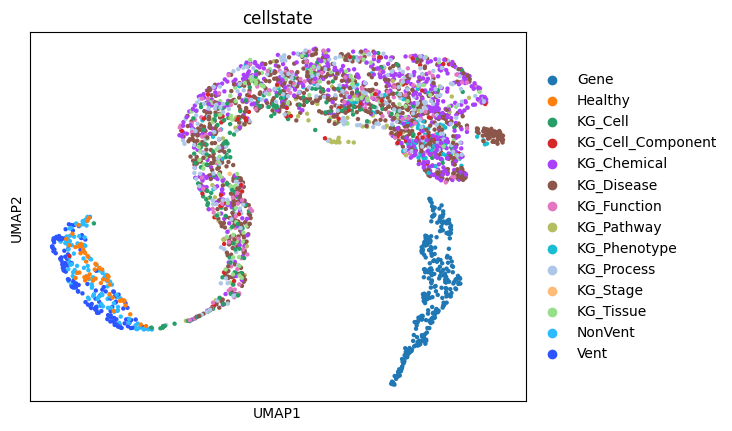

In [17]:
adata_graph.uns['cellstate_colors'] = ['#1f77b4','#ff7f0e','#279e68','#d62728','#aa40fc',
                                       '#8c564b','#e377c2','#b5bd61','#17becf','#aec7e8',
                                       '#ffbb78','#98df8a','#2dbbff','#2d55ff']

sc.pl.umap(adata_graph, color = 'cellstate')

## rank chemicals related to diseases
use cosine similarity to find potential drugs for disease

In [18]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import seaborn as sns

In [19]:
adata_graph_chemical = adata_graph[adata_graph.obs['cellstate'] == 'KG_Chemical']
adata_graph_covid = adata_graph[adata_graph.obs['cellstate'] == 'KG_Disease']


emb1 = adata_graph_chemical.X
emb2 = adata_graph_covid.X
dist = cosine_similarity(emb1, emb2)

dist_map = pd.DataFrame(dist)
dist_map.columns = adata_graph_covid.obs_names
dist_map.index = adata_graph_chemical.obs_names

/home/share/huadjyin/home/s_caolei2/.conda/envs/openhgnn/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/share/huadjyin/home/s_caolei2/.conda/envs/openhgnn/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


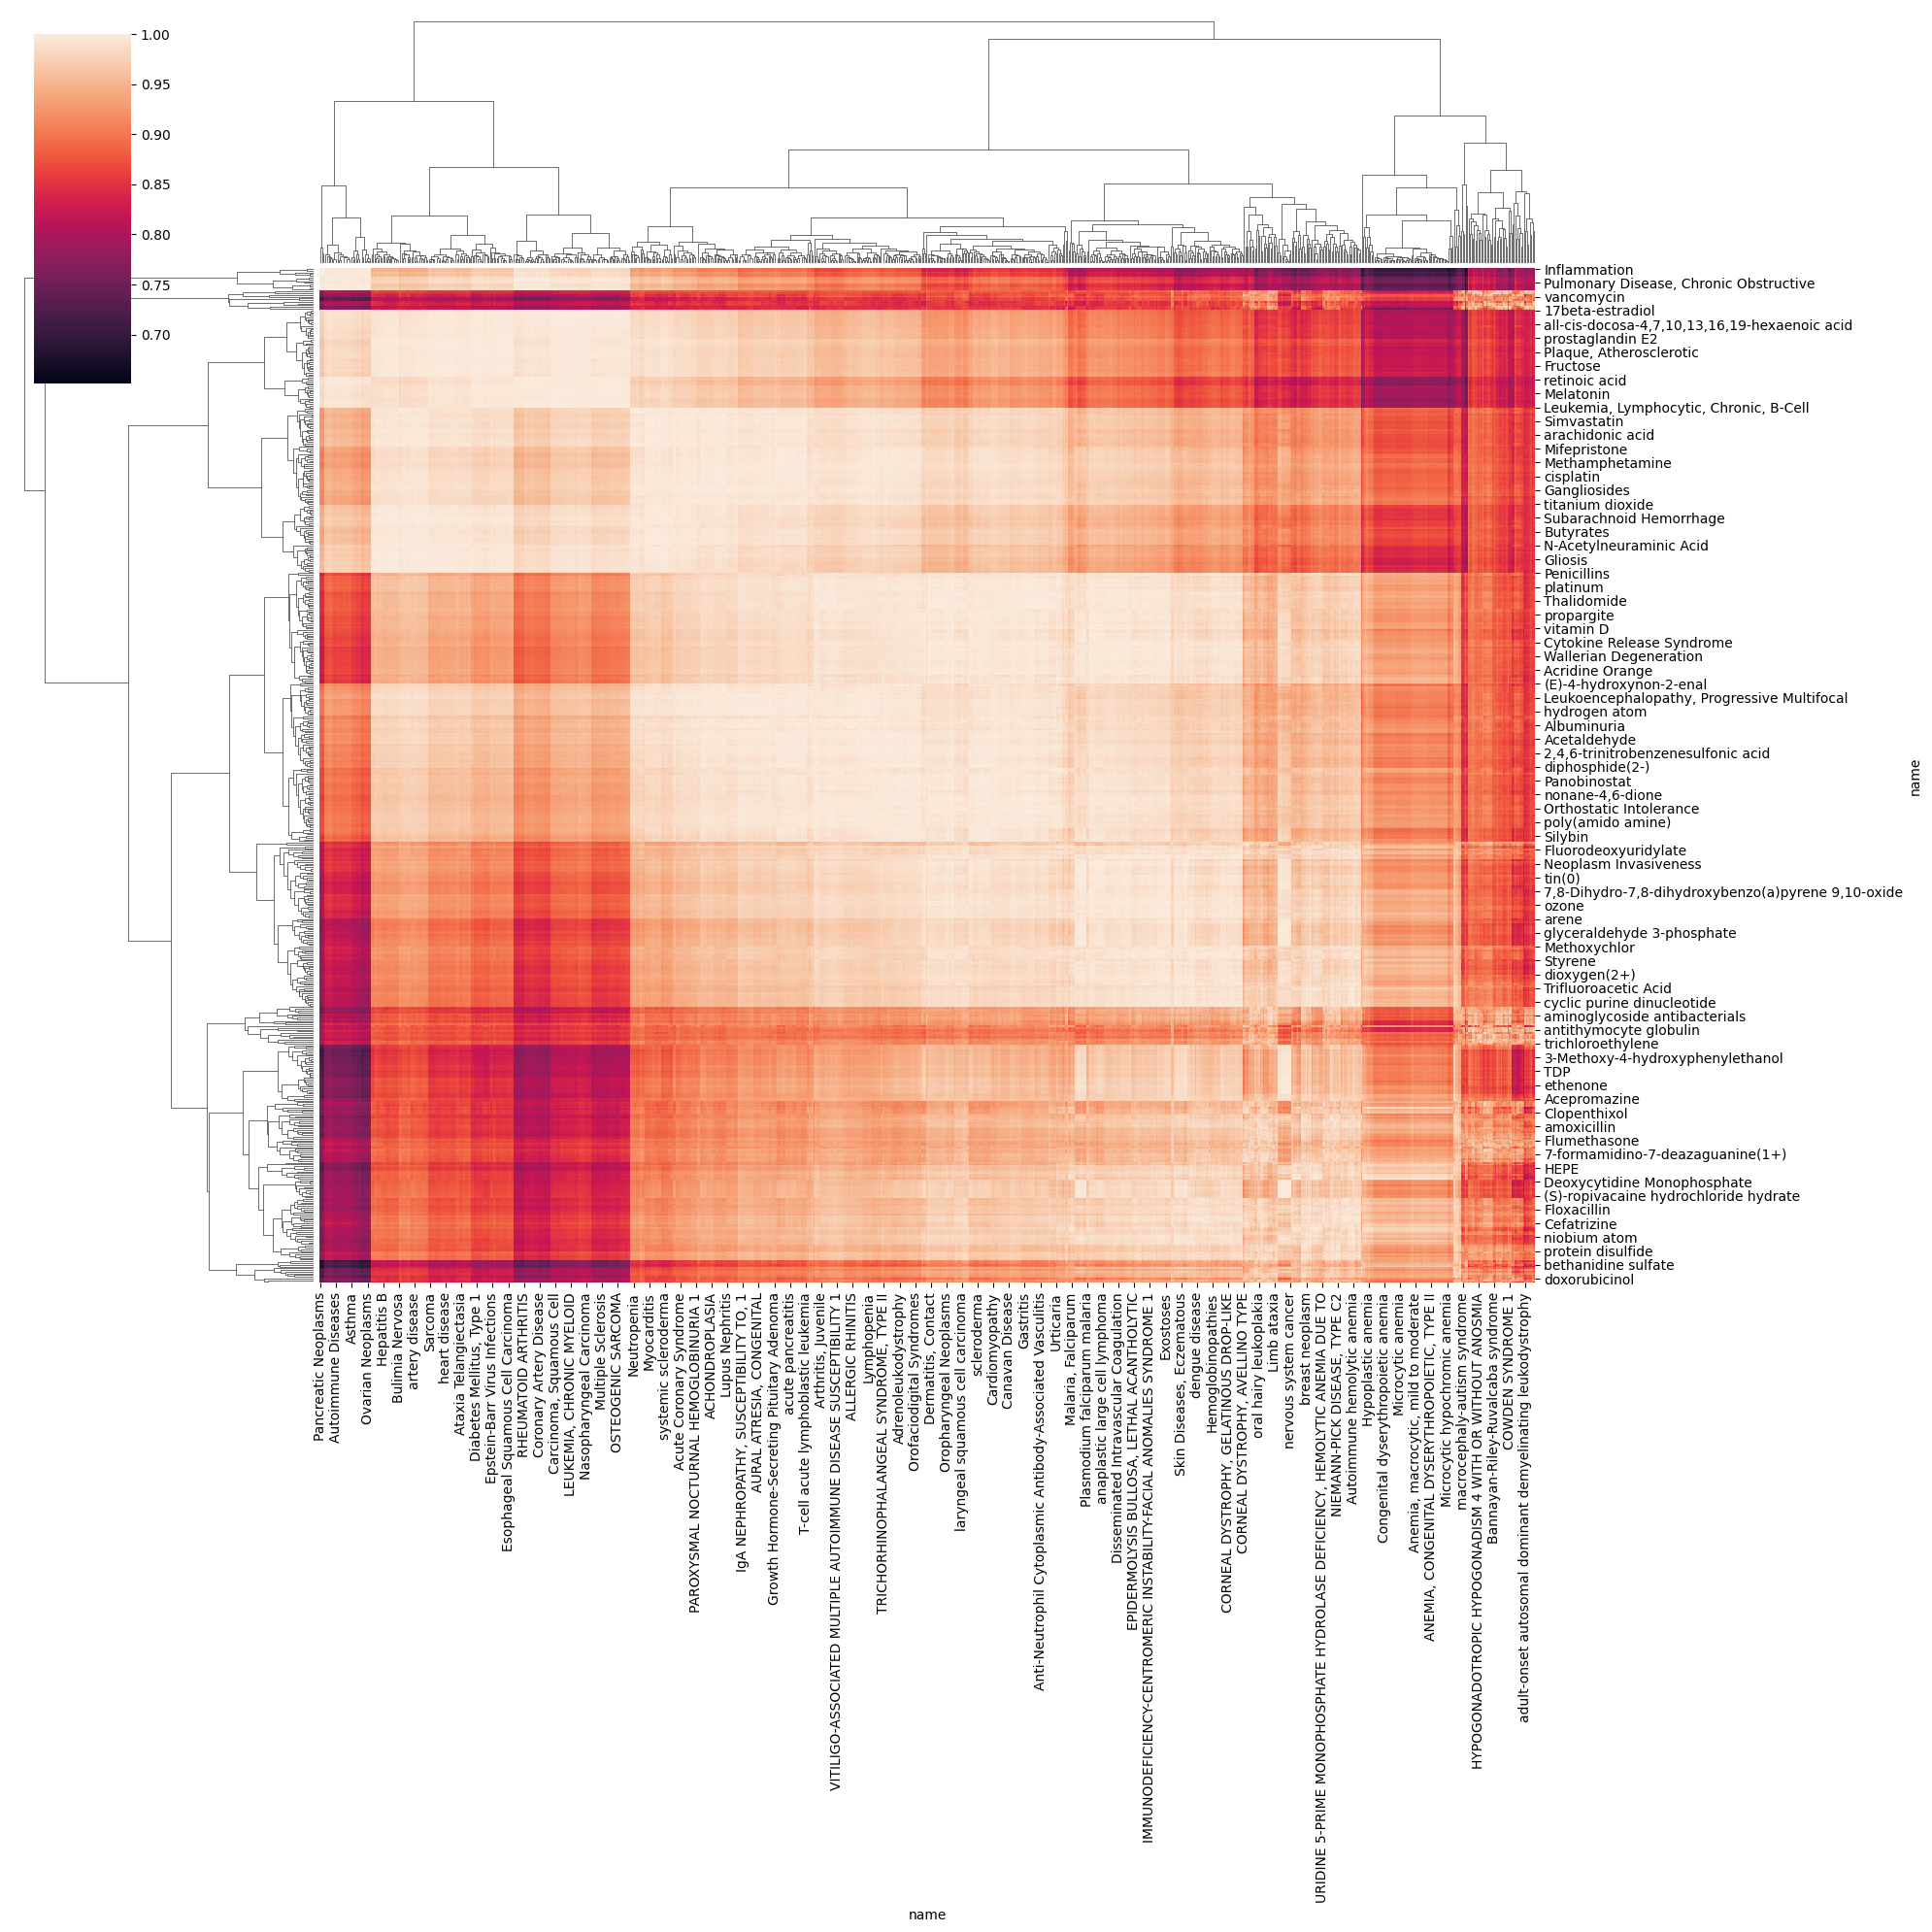

In [20]:
sns.clustermap(dist_map, figsize=(20, 20))

### to show a specific result, we can also visualize the top 30 chemicals and disease

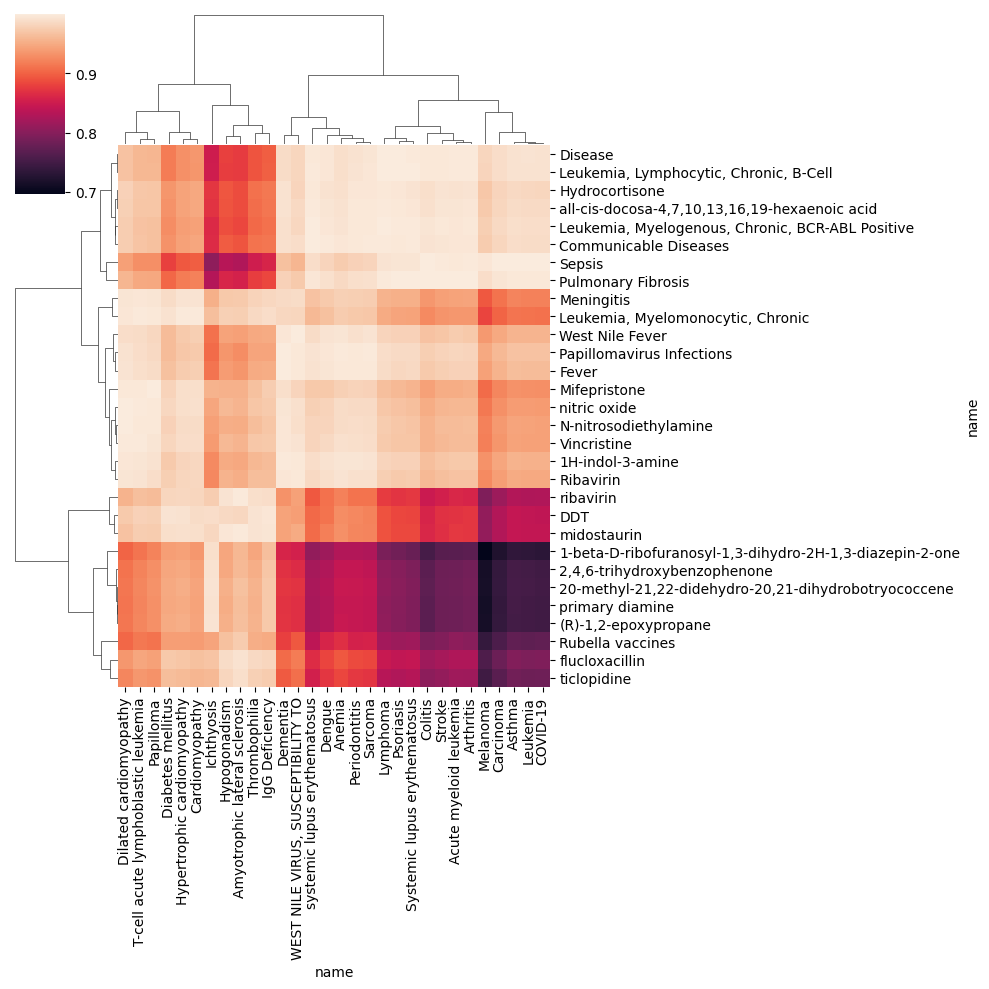

In [21]:
sub_set_disease = df_count_filtered.loc[df_count_filtered['path.2.type'] == 'Disease'].sort_values('pvalue').head(30)['path.2.name']
sub_set_chemical = df_count_filtered.loc[df_count_filtered['path.2.type'] == 'Chemical'].sort_values('pvalue').head(30)['path.2.name']

dist_map_sub = dist_map.loc[sub_set_chemical, sub_set_disease]
sns.clustermap(dist_map_sub, figsize=(10, 10))

## Analysis of COVID-19

In [55]:
df_covid = dist_map[['COVID-19']].sort_values('COVID-19', ascending=False)
df_covid.columns = ['cosine_similiarity']

we can also calculate the Euclidean distance between chemicals and diseases

In [56]:
import numpy as np

eu_dist = dist = np.array([ np.linalg.norm(emb1 - x, axis=1) for x in emb2]).T

eu_dist_map = pd.DataFrame(eu_dist)
eu_dist_map.columns = adata_graph_covid.obs_names
eu_dist_map.index = adata_graph_chemical.obs_names

df_covid['euclidean_distance'] = eu_dist_map['COVID-19']
df_covid.head()

,cosine_similiarity,euclidean_distance
name,,
Cisplatin,0.999093,0.008380
Sepsis,0.999086,0.009338
Nitric Oxide,0.998965,0.011225
Superoxides,0.998962,0.009062
NADPH(4-),0.998421,0.012337


Text(0, 0.5, 'euclidean distance')

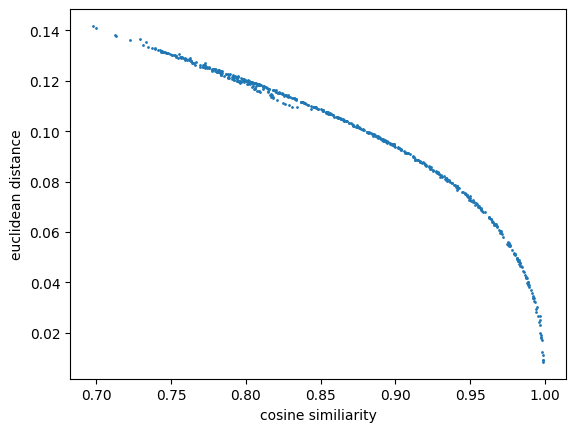

In [34]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(df_covid['cosine_similiarity'], df_covid['euclidean_distance'], s=1)

ax.set_xlabel('cosine similiarity')
ax.set_ylabel('euclidean distance')

## Compare predicted potential drugs with real drug for COVID-19

In [35]:
# abort

drug_df = pd.read_csv('./drug_df.csv', index_col=0)

In [35]:
drug_df = BRICK.qr.query_neighbor(['COVID-19'], source_entity_type='Disease', target_entity_type='Chemical', relation='pharmaco_effect_on')
drug_df.head()

,path.0.def,path.0.id,path.0.name,path.0.synonym,path.0.type,path.1,path.1.condition,path.1.info_source,path.1.info_source_length,path.1.original_relation,path.1.relation,path.2.def,path.2.id,path.2.name,path.2.synonym,path.2.type
0,A viral disorder generally characterized by hi...,MESH:D000086382,COVID-19,Undef,Disease,pharmaco_effect_on,"['Undef', 'Undef', 'Undef']","['CLINICALTRAILS:NCT04885530', 'CLINICALTRAILS...",3,"['pharmaco_effect_on', 'pharmaco_effect_on', '...",pharmaco_effect_on,A STEROID with GLUCOCORTICOID RECEPTOR activit...,MESH:D000068298,Fluticasone,Undef,Chemical
1,A viral disorder generally characterized by hi...,MESH:D000086382,COVID-19,Undef,Disease,pharmaco_effect_on,['Undef'],['CLINICALTRAILS:NCT04729491'],1,['pharmaco_effect_on'],pharmaco_effect_on,A 5-ALPHA-REDUCTASE INHIBITOR that is reported...,MESH:D000068538,Dutasteride,Undef,Chemical
2,A viral disorder generally characterized by hi...,MESH:D000086382,COVID-19,Undef,Disease,pharmaco_effect_on,['Undef'],['CLINICALTRAILS:NCT04631536'],1,['pharmaco_effect_on'],pharmaco_effect_on,A cardioselective ADRENERGIC BETA-1 RECEPTOR A...,MESH:D000068577,Nebivolol,Undef,Chemical
3,A viral disorder generally characterized by hi...,MESH:D000086382,COVID-19,Undef,Disease,pharmaco_effect_on,"['Undef', 'Undef', 'Undef', 'Undef']","['CLINICALTRAILS:NCT04488081', 'CLINICALTRAILS...",4,"['pharmaco_effect_on', 'pharmaco_effect_on', '...",pharmaco_effect_on,A pyrazole derivative and selective CYCLOOXYGE...,MESH:D000068579,Celecoxib,Undef,Chemical
4,A viral disorder generally characterized by hi...,MESH:D000086382,COVID-19,Undef,Disease,pharmaco_effect_on,['Undef'],['CLINICALTRAILS:NCT04484493'],1,['pharmaco_effect_on'],pharmaco_effect_on,A pregnadienediol derivative ANTI-ALLERGIC AGE...,MESH:D000068656,Mometasone Furoate,Undef,Chemical


In [57]:
real_drugs = list(drug_df['path.2.name'])
df_covid['is_real_drug'] = [x in real_drugs for x in df_covid.index]

df_covid.head(15)

,cosine_similiarity,euclidean_distance,is_real_drug
name,,,
Cisplatin,0.999093,0.008380,False
Sepsis,0.999086,0.009338,False
Nitric Oxide,0.998965,0.011225,True
Superoxides,0.998962,0.009062,False
NADPH(4-),0.998421,0.012337,False
Sirolimus,0.997838,0.017142,True
"Pulmonary Disease, Chronic Obstructive",0.997703,0.019014,False
Phosphatidylinositols,0.997480,0.018261,False
Androgens,0.997431,0.017937,True


Text(0, 0.5, 'euclidean distance')

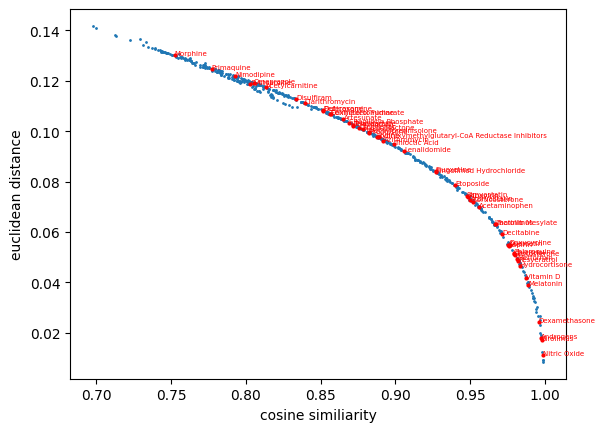

In [65]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

df_covid_real = df_covid.loc[df_covid['is_real_drug']]
df_covid_new_find = df_covid.loc[~df_covid['is_real_drug']]
ax.scatter(df_covid_new_find['cosine_similiarity'], df_covid_new_find['euclidean_distance'], s=1)
ax.scatter(df_covid_real['cosine_similiarity'], df_covid_real['euclidean_distance'], s=4, color='red')

for x, row in df_covid_real.iterrows():
    ax.text(row['cosine_similiarity'], row['euclidean_distance'], x, color='red', fontsize=5)

ax.set_xlabel('cosine similiarity')
ax.set_ylabel('euclidean distance')

## Dynamic change During representive learning 

In [69]:
model = BRICK.emb.GRACE_model(nxg, device='cuda:1')

In [70]:
for i in range(100):
    model.fit(epoches=10)
    adata_graph.layers[f'{i*10}_epoch'] = model.get_embbedding()

(T):   0%|          | 0/10 [00:00<?, ?it/s]/home/share/huadjyin/home/s_caolei2/.conda/envs/openhgnn/lib/python3.8/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)
(T): 100%|██████████| 10/10 [00:00<00:00, 67.68it/s, loss=6.09]


In [77]:
adata_graph

AnnData object with n_obs × n_vars = 2990 × 32
    obs: 'name', 'type', 'cellstate'
    uns: 'neighbors', 'umap', 'cellstate_colors'
    obsm: 'X_umap'
    layers: '0_epoch', '10_epoch', '20_epoch', '30_epoch', '40_epoch', '50_epoch', '60_epoch', '70_epoch', '80_epoch', '90_epoch', '100_epoch', '110_epoch', '120_epoch', '130_epoch', '140_epoch', '150_epoch', '160_epoch', '170_epoch', '180_epoch', '190_epoch', '200_epoch', '210_epoch', '220_epoch', '230_epoch', '240_epoch', '250_epoch', '260_epoch', '270_epoch', '280_epoch', '290_epoch', '300_epoch', '310_epoch', '320_epoch', '330_epoch', '340_epoch', '350_epoch', '360_epoch', '370_epoch', '380_epoch', '390_epoch', '400_epoch', '410_epoch', '420_epoch', '430_epoch', '440_epoch', '450_epoch', '460_epoch', '470_epoch', '480_epoch', '490_epoch', '500_epoch', '510_epoch', '520_epoch', '530_epoch', '540_epoch', '550_epoch', '560_epoch', '570_epoch', '580_epoch', '590_epoch', '600_epoch', '610_epoch', '620_epoch', '630_epoch', '640_epoch', '6

In [87]:
adata_graph_chemical = adata_graph[adata_graph.obs['cellstate'] == 'KG_Chemical']
adata_graph_covid = adata_graph[adata_graph.obs['name'] == 'COVID-19']


for epoch in range(100):
    emb1 = adata_graph_chemical.layers[f'{epoch*10}_epoch']
    emb2 = adata_graph_covid.layers[f'{epoch*10}_epoch']
    dist = cosine_similarity(emb1, emb2)

    dist_map_tmp = pd.DataFrame(dist)
    dist_map_tmp.index = adata_graph_chemical.obs_names
    df_covid[f'{epoch*10}_epoch'] = dist_map_tmp[0]

/tmp/ipykernel_2048249/3300262931.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_covid[f'{epoch*10}_epoch'] = dist_map_tmp[0]
/tmp/ipykernel_2048249/3300262931.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_covid[f'{epoch*10}_epoch'] = dist_map_tmp[0]
/tmp/ipykernel_2048249/3300262931.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get

In [89]:
df_covid.head()

,cosine_similiarity,euclidean_distance,is_real_drug,990_epoch,0_epoch,10_epoch,20_epoch,30_epoch,40_epoch,50_epoch,...,890_epoch,900_epoch,910_epoch,920_epoch,930_epoch,940_epoch,950_epoch,960_epoch,970_epoch,980_epoch
name,,,,,,,,,,,,,,,,,,,,,
Cisplatin,0.999093,0.008380,False,0.999051,0.994747,0.997715,0.998925,0.999296,0.999525,0.999672,...,0.999251,0.999225,0.999204,0.999180,0.999153,0.999130,0.999109,0.999092,0.999076,0.999064
Sepsis,0.999086,0.009338,False,0.998949,0.996419,0.998911,0.999324,0.999602,0.999782,0.999869,...,0.998952,0.998960,0.998963,0.998964,0.998962,0.998964,0.998962,0.998959,0.998954,0.998954
Nitric Oxide,0.998965,0.011225,True,0.998933,0.993696,0.999032,0.999415,0.999636,0.999754,0.999838,...,0.999148,0.999122,0.999094,0.999067,0.999040,0.999019,0.998998,0.998979,0.998961,0.998947
Superoxides,0.998962,0.009062,False,0.998837,0.995369,0.998487,0.999281,0.999630,0.999814,0.999892,...,0.999104,0.999071,0.999038,0.999005,0.998971,0.998944,0.998917,0.998893,0.998871,0.998855
NADPH(4-),0.998421,0.012337,False,0.998137,0.995858,0.998573,0.999192,0.999552,0.999777,0.999866,...,0.998412,0.998382,0.998351,0.998315,0.998280,0.998254,0.998227,0.998201,0.998175,0.998158


In [92]:
xtick = [10*i for i in range(100)]
df_covid_drug = df_covid[[f'{x}_epoch' for x in xtick]].T

### calculate drug trend

use pearson correlation to indicate the tendency of similiarity to COVID during training epoches

In [95]:
from scipy.stats import pearsonr

pearson_dict = {}
for x in df_covid_drug:
    pearson_dict[x] = pearsonr(df_covid_drug[x], xtick).correlation
pearson_df = pd.DataFrame([pearson_dict]).T
df_covid['pearson'] = pearson_df[0]

Text(0, 0.5, 'pearson')

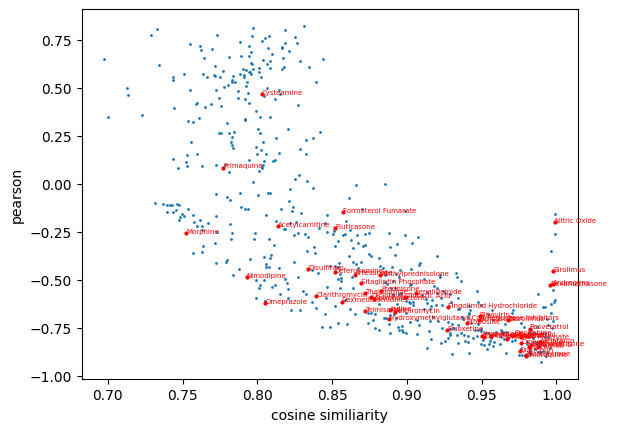

In [101]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

df_covid_real = df_covid.loc[df_covid['is_real_drug']]
df_covid_new_find = df_covid.loc[~df_covid['is_real_drug']]
ax.scatter(df_covid_new_find['cosine_similiarity'], df_covid_new_find['pearson'], s=1)
ax.scatter(df_covid_real['cosine_similiarity'], df_covid_real['pearson'], s=4, color='red')

for x, row in df_covid_real.iterrows():
    ax.text(row['cosine_similiarity'], row['pearson'], x, color='red', fontsize=5)

ax.set_xlabel('cosine similiarity')
ax.set_ylabel('pearson')